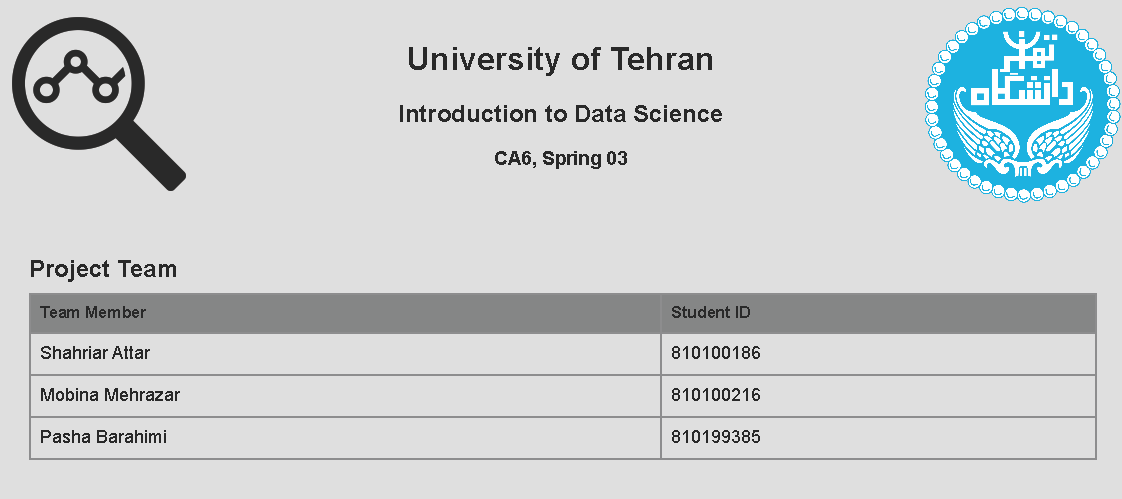

# Dimensionality Reduction and Unsupervised Learning

## Table of Contents

- [Introduction](#introduction)
- [Objectives](#objectives)
- [Tasks](#tasks)
- [Dataset Description](#dataset-description)
- [Environment Setup](#environment-setup)
- [Preprocessing](#preprocessing)
- [Dimensionality Reduction](#dimensionality-reduction)
- [Unsupervised Learning](#unsupervised-learning)
  - [Silhouette Method](#silhouette-method)
  - [K-Means](#k-means)
  - [DBSCAN](#dbscan)
- [Questions](#questions)
- [References](#references)

## Introduction

In this assignment, we will delve into dimensionality reduction and unsupervised learning tasks. Firstly, we should preprocess the provided dataset to prepare it for analysis. Next, we will apply dimensionality reduction techniques to simplify the dataset's complexity. Then, we will use unsupervised learning algorithms to tackle the task. Finally, we evaluate and analyze the results for comparison.

## Objectives

This assignment aims to:

- Implementing dimensionality reduction to simplify the dataset's complexity.
- Using unsupervised learning algorithms to tackle the task.

## Tasks

1. Preprocessing
2. Dimensionality Reduction
3. Unsupervised Learning
4. Evaluation and Analyzing the Results for Comparison

## Dataset Description

In 2014, some researchers published an article called "[Impact of c1HbA Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records.](https://www.hindawi.com/journals/bmri/2014/781670/)" They gathered data on diabetic patients from many hospitals and clinics in America. Some of this data, about 200,000 items with 50 features, has been shared with the public in a way that keeps people's identities private.

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.


## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [1]:
from typing import Union

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tqdm
import pickle

import pandas as pd
from pandas.plotting import scatter_matrix

from tabulate import tabulate

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from mpl_toolkits.mplot3d import Axes3D

In [2]:
DIABETIC_DATA = "../data/diabetic_data.csv"

In [3]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [4]:
df = pd.read_csv(DIABETIC_DATA)
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


## Preprocessing

Data Preprocessing or Data Preparation is a data mining technique that transforms raw data into an understandable format for ML algorithms. Real-world data is usually noisy (contains errors, outliers, duplicates), incomplete (some values are missed), and could be stored in different places and different formats. The task of Data Preprocessing is to handle these issues.

The dataset contains both numerical and textual values, along with outliers and null values. These inconsistencies can disrupt clustering accuracy. We'll normalize the data extensively and provide detailed explanations for each normalization step in the report file.

Let's drop the duplicates.

In [5]:
duplicates = df.duplicated(subset="patient_nbr").sum()
uniques = df["patient_nbr"].nunique()
print(f"Number of duplicate patients: {duplicates}")
print(f"Number of unique patients: {uniques}")

Number of duplicate patients: 30248
Number of unique patients: 71518


We may have multiple entries for the same patient. First, we'll find the number of patients with unique entries and the number of patients with multiple entries.

In [6]:
patients_unique_entires = df.value_counts("patient_nbr")[df.value_counts("patient_nbr") == 1].shape[0]
patients_dup_entires = df.value_counts("patient_nbr")[df.value_counts("patient_nbr") > 1].shape[0]
print(f"Patients with unique entries: {patients_unique_entires}")
print(f"Patients with duplicate entries: {patients_dup_entires}")

Patients with unique entries: 54745
Patients with duplicate entries: 16773


Then, we'll drop the duplicates and keep only the last entry for each patient.

In [7]:
df = df.drop_duplicates(subset="patient_nbr", keep="last")

Now, we don't need the `patient_nbr` column, so we'll drop it.

In [8]:
df = df.drop(columns=["patient_nbr"], axis=1)

We also have some '?' values in the dataset. We'll replace them with NaN values.

In [9]:
df = df.replace("?", np.nan)

Also, there are some values in `IDs_mapping.csv` that mean 'Unknown', 'Not Available', 'Not Mapped', 'NULL', and etc. We'll replace them with NaN values.

In [10]:
def replace_values_with_nan(df: pd.DataFrame, replacements: dict[str, list[int]]) -> pd.DataFrame:
    for column, values in replacements.items():
        for value in values:
            df[column] = df[column].replace(value, np.nan)

    df[list(replacements.keys())] = df[list(replacements.keys())].astype("object")
    return df

In [11]:
replacements = {
    "admission_type_id": [5, 6, 8],
    "discharge_disposition_id": [18, 25, 26],
    "admission_source_id": [9, 15, 17, 20, 21],
}

df = replace_values_with_nan(df, replacements)

Let's check the number of missing values in each column.

In [12]:
df.isnull().sum()

encounter_id                    0
race                         1878
gender                          0
age                             0
weight                      68671
admission_type_id            7444
discharge_disposition_id     2964
admission_source_id          5133
time_in_hospital                0
payer_code                  30085
medical_specialty           34525
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         17
diag_2                        290
diag_3                       1146
number_diagnoses                0
max_glu_serum               68041
A1Cresult                   59120
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

Then, we'll find out the null values percentage in each column.

In [13]:
def get_null_percentage(df: pd.DataFrame) -> list[list]:
    percent_null_per_column = df.isnull().sum() / df.shape[0] * 100
    results = [[column, percent_null] for column, percent_null in percent_null_per_column.items() if percent_null > 0]
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def display_null_percentage(df: pd.DataFrame) -> None:
    results = get_null_percentage(df)
    formatted_results = [[col, f"{val:.2f}%"] for col, val in results]
    print(tabulate(formatted_results, headers=["Column", "Percentage of Null Values"], tablefmt="grid"))

In [14]:
display_null_percentage(df)

+--------------------------+-----------------------------+
| Column                   | Percentage of Null Values   |
+==========================+=============================+
| weight                   | 96.02%                      |
+--------------------------+-----------------------------+
| max_glu_serum            | 95.14%                      |
+--------------------------+-----------------------------+
| A1Cresult                | 82.66%                      |
+--------------------------+-----------------------------+
| medical_specialty        | 48.27%                      |
+--------------------------+-----------------------------+
| payer_code               | 42.07%                      |
+--------------------------+-----------------------------+
| admission_type_id        | 10.41%                      |
+--------------------------+-----------------------------+
| admission_source_id      | 7.18%                       |
+--------------------------+----------------------------

Some columns have a high percentage of missing values. We'll drop these columns.

In [15]:
def drop_columns_with_high_null_percentage(df: pd.DataFrame, threshold: float = 80) -> pd.DataFrame:
    results = get_null_percentage(df)
    columns_to_drop = [col for col, val in results if val > threshold]
    print(f"Dropping columns with more than {threshold}% null values: {columns_to_drop}")
    return df.drop(columns=columns_to_drop, axis=1)

In [16]:
df = drop_columns_with_high_null_percentage(df, 40)

Dropping columns with more than 40% null values: ['weight', 'max_glu_serum', 'A1Cresult', 'medical_specialty', 'payer_code']


In [17]:
display_null_percentage(df)

+--------------------------+-----------------------------+
| Column                   | Percentage of Null Values   |
+==========================+=============================+
| admission_type_id        | 10.41%                      |
+--------------------------+-----------------------------+
| admission_source_id      | 7.18%                       |
+--------------------------+-----------------------------+
| discharge_disposition_id | 4.14%                       |
+--------------------------+-----------------------------+
| race                     | 2.63%                       |
+--------------------------+-----------------------------+
| diag_3                   | 1.60%                       |
+--------------------------+-----------------------------+
| diag_2                   | 0.41%                       |
+--------------------------+-----------------------------+
| diag_1                   | 0.02%                       |
+--------------------------+----------------------------

Let's also encode the columns.

In [18]:
all_columns = df.select_dtypes(include=["object"]).columns.tolist()
ordinal_columns = ["age"]
label_columns = [col for col in all_columns if col not in ordinal_columns]

print(label_columns)

['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [19]:
label_encoders = {}

for col in ordinal_columns:
    ordinal_encoder = LabelEncoder()
    df[col] = ordinal_encoder.fit_transform(df[col])

for col in label_columns:
    if col not in label_encoders:
        label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

Then, we'll impute the missing values.

In [20]:
knn_imputer = KNNImputer()
df_imputed = knn_imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              71518 non-null  float64
 1   race                      71518 non-null  float64
 2   gender                    71518 non-null  float64
 3   age                       71518 non-null  float64
 4   admission_type_id         71518 non-null  float64
 5   discharge_disposition_id  71518 non-null  float64
 6   admission_source_id       71518 non-null  float64
 7   time_in_hospital          71518 non-null  float64
 8   num_lab_procedures        71518 non-null  float64
 9   num_procedures            71518 non-null  float64
 10  num_medications           71518 non-null  float64
 11  number_outpatient         71518 non-null  float64
 12  number_emergency          71518 non-null  float64
 13  number_inpatient          71518 non-null  float64
 14  diag_1

In [21]:
df_imputed.isnull().sum().sum()

0

In [22]:
df = df_imputed
df = df.drop_duplicates()

We should also remove the outliers.

In [23]:
def plot_horizontal_box_plot(df, columns):
    plt.figure(figsize=(10, 6))
    df[columns].boxplot(vert=0)
    plt.title("Horizontal Boxplot of Specified Columns")
    plt.xlabel("Values")
    plt.ylabel("Columns")
    plt.show()

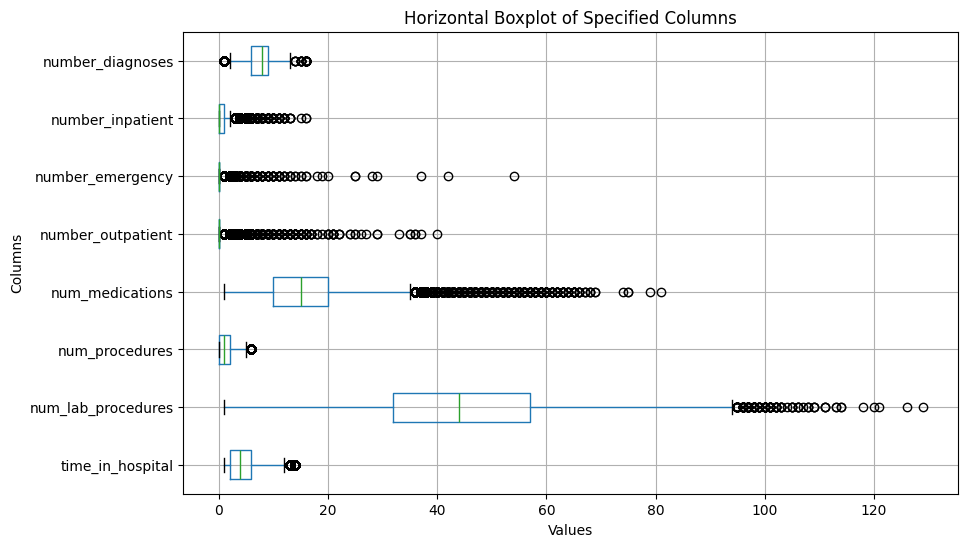

In [24]:
plot_horizontal_box_plot(df, ["time_in_hospital",
                              "num_lab_procedures",
                              "num_procedures",
                              "num_medications",
                              "number_outpatient",
                              "number_emergency",
                              "number_inpatient",
                              "number_diagnoses"])

In [25]:
def delete_outliers(df: pd.DataFrame, columns: list[str], threshold: float = 0.05) -> pd.DataFrame:
    isolation_forest = IsolationForest(contamination=threshold)
    outliers = isolation_forest.fit_predict(df[columns])
    return df.loc[outliers == 1]

In [26]:
df = delete_outliers(df, df.select_dtypes(include=["int64", "float64"]).columns.tolist(), 0.1)

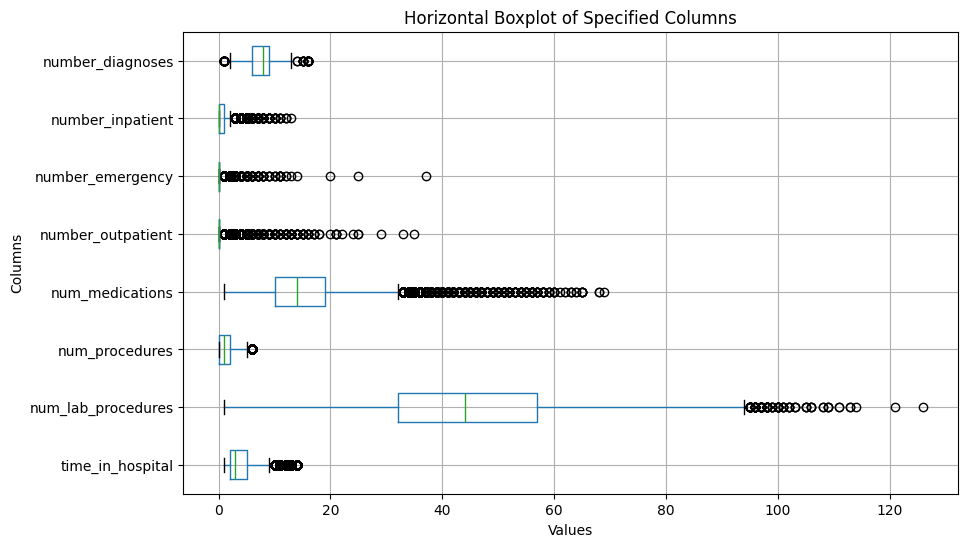

In [27]:
plot_horizontal_box_plot(df, ["time_in_hospital",
                              "num_lab_procedures",
                              "num_procedures",
                              "num_medications",
                              "number_outpatient",
                              "number_emergency",
                              "number_inpatient",
                              "number_diagnoses"])

In [28]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64366 entries, 0 to 64365
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              64366 non-null  float64
 1   race                      64366 non-null  float64
 2   gender                    64366 non-null  float64
 3   age                       64366 non-null  float64
 4   admission_type_id         64366 non-null  float64
 5   discharge_disposition_id  64366 non-null  float64
 6   admission_source_id       64366 non-null  float64
 7   time_in_hospital          64366 non-null  float64
 8   num_lab_procedures        64366 non-null  float64
 9   num_procedures            64366 non-null  float64
 10  num_medications           64366 non-null  float64
 11  number_outpatient         64366 non-null  float64
 12  number_emergency          64366 non-null  float64
 13  number_inpatient          64366 non-null  float64
 14  diag_1

In [29]:
df.columns.size

44

We should also normalize the data.

In [30]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)

## Dimensionality Reduction

Some data mining algorithms, like K-Means, struggle with accurately clustering data when confronted with numerous features, leading to high dimensionality. This issue isn't exclusive to datasets with hundreds or thousands of features; even just ten features can pose accuracy challenges. Feature or dimensionality reduction aims to address this by transforming the original feature set into a smaller set of derived features that retain most of the original information.

Principal Component Analysis (PCA) is a widely used technique for feature reduction. It condenses the original dataset into a set number of features known as principal components. The desired number of principal components must be specified. In this section, we'll utilize PCA to reduce the dimensionality of the dataset. This approach is recommended if there are numerous variables, manual variable selection is impractical, or segmentation results are unsatisfactory.

In [35]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

In [36]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
# print("Principal components:", pca.components_)
# print("Mean vector:", pca.mean_)
print("Singular values:", pca.singular_values_)
print("Number of components:", pca.n_components_)
# print("Number of features:", pca.n_features_)
print("Number of samples:", pca.n_samples_)

Explained variance ratio: [0.25394652 0.08331822 0.07234254]
Singular values: [147.71580992  84.61080591  78.8411081 ]
Number of components: 3
Number of samples: 64366


In [37]:
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
n_components_to_explain_80_percent = (explained_variance_ratio_cumsum <= 0.8).sum() + 1

pca = PCA(n_components=n_components_to_explain_80_percent)
X_pca = pca.fit_transform(X)

print(pca.components_.shape)
print(X_pca.shape[1])

(4, 44)
4


In [38]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: 0.4695660500764642


## Unsupervised Learning

### Silhouette Method

The Silhouette Method is a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its cluster compared to other clusters, by providing a succinct graphical representation of how well each object has been classified.

In [32]:
# code

### K-Means

K-Means Clustering is a type of Unsupervised Machine Learning algorithm that organizes an unlabeled dataset into distinct clusters. This method assigns data points to one of the K clusters based on their proximity to the cluster centers. Initially, cluster centroids are randomly placed in space. Then, each data point is assigned to the nearest cluster centroid. Subsequently, new cluster centroids are calculated. This iterative process continues until it converges on well-defined clusters.

In [33]:
# code

### DBSCAN

DBSCAN is an unsupervised clustering algorithm, offering an alternative to KMeans and hierarchical clustering. It relies on two key parameters: Epsilon (ɛ), defining the neighborhood radius, and Minimum Points (minPts), specifying the minimum number of points to form a cluster. Epsilon determines the similarity threshold between points, influencing cluster size, while minPts affects cluster robustness and noise handling. Balancing these parameters is crucial for effective clustering without splitting valid clusters or aggregating unrelated points.

In [34]:
# code

Utilizing the silhouette method, we'll determine the optimal number of clusters for the K-means method and the optimal input parameters (minPnt, eps) for the DBSCAN method. Based on the obtained values, we will then store the best result from each method in a CSV file containing only the columns: id_encounter, kmean_label, and dbscan_label.

## Questions

1. **What preprocessing steps did you perform on the dataset? Provide clear reasons for each decision made.**

2. **What portion of the dataset did you retain during dimensionality reduction, and which variables were retained? Could you elaborate on the rationale behind this decision?**

3. **Include a plot illustrating the silhouette coefficient plotted against the input parameters for each clustering method within the report file.**

4. **How can we determine the optimal number of clusters in K-Means?**

5. **How can we determine the optimal epsilon value and minPts in DBSCAN?**

6. **When would you recommend using K-Means, and when would you suggest using DBSCAN instead?**

## References

- [Dataset](https://www.hindawi.com/journals/bmri/2014/781670/)
- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Silhouette Method](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Silhouette Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [K-Means](https://en.wikipedia.org/wiki/K-means_clustering)
- [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)
- [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
